In [83]:
in_path =r'../../data/clean/' # use your path
out_path=r'../../data/clean/'

import pandas as pd
pd.set_option('display.max_columns', 500)
import glob
import re
from nltk import stem
porter = stem.porter.PorterStemmer()
from gensim import corpora, models, similarities
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
    df=pd.read_csv(in_path+"articles.csv")   
    df['doc']=df.AB+'. '+df.TI+'. '+df.DE

In [85]:
    docs_csv=out_path+"docs.csv"
    df.doc.to_csv(docs_csv, index=False)
    
    with open(docs_csv) as f:
        docs = f.readlines()

In [86]:
docs_cleaned = [[re.sub('[.!,;?()\W\d]+', '', word) for word in doc.lower().split()] for doc in docs]
stop= open ('stopList.txt').read()
stop_list = set(stop.replace("\n", " ").split())
stop_list.remove('information')

In [88]:
    docs_stemed = [[porter.stem(word) for word in document if word not in stop_list] for document in docs_cleaned]
    docs_prepared=out_path+'docs_prepared.csv'
    with open(docs_prepared, 'w') as f:
        for doc in docs_stemed:f.write("%s\n" % ' '.join(doc))        

In [89]:
dictionary = corpora.Dictionary(docs_stemed)
dictionary.filter_extremes(no_below=5)
dictionary.compactify() 
print dictionary

class MyCorpus(object):
    def __iter__(self):
        for doc in docs_stemed:
            yield dictionary.doc2bow(doc)
corpus= MyCorpus() 
corpora.MmCorpus.serialize('serialized.mm', corpus)
corpus = corpora.MmCorpus('serialized.mm')
print corpus

Dictionary(2633 unique tokens: [u'', u'assimil', u'interchang', u'articul', u'payoff']...)
MmCorpus(2101 documents, 2633 features, 130760 non-zero entries)


In [90]:
    tfidf = models.tfidfmodel.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100) 
    corpus_lsi=lsi[corpus_tfidf]

    index = similarities.MatrixSimilarity(corpus_lsi) 
    lines = docs_stemed
    sims = open('../csv/lsi.csv', 'w')
    sims.write('source,target,weight,type\n')
    for i in range(len(docs_stemed)):
        doc=lines[i]    
        vec_bow = dictionary.doc2bow(doc)
        vec_tran = lsi[tfidf[vec_bow]]
        #vec_tran = lda[tfidf[vec_bow]]
        simsinx = index[vec_tran]
        for j in range(i+1,len(simsinx)):
            if simsinx[j]>.5:                                        
                sims.write(str(i)+','+str(j)+','+str(simsinx[j])+',undirected\n')
    sims.close()

In [91]:
lsi_df=pd.read_csv('../csv/lsi.csv')
lsi_df=lsi_df[lsi_df.weight>.5]
lsi_df.shape

(24265, 4)

In [92]:
n=max(lsi_df.source.max(),lsi_df.target.max())
mm=np.zeros((n+1,n+1))
mm.shape

(2101L, 2101L)

In [93]:
for row in lsi_df.iterrows():
    mm[row[1][0],row[1][1]]=row[1][2]

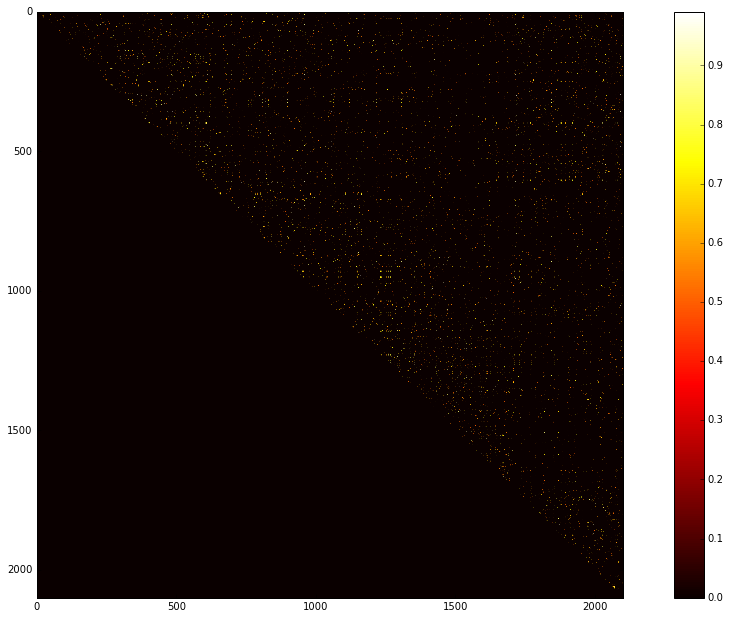

In [96]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.imshow(mm, cmap=plt.cm.hot)
plt.colorbar()
plt.show()

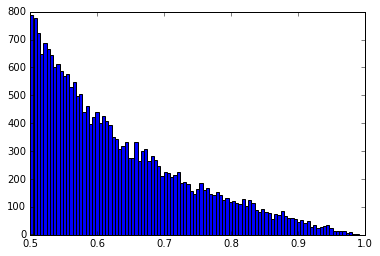

In [97]:
import numpy as np
l=lsi_df.weight
hist=plt.hist(l,101)

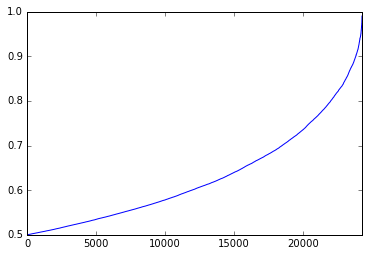

In [98]:
l=l.sort_values()
l=l.reset_index(drop=True)
l.plot(drawstyle='steps')

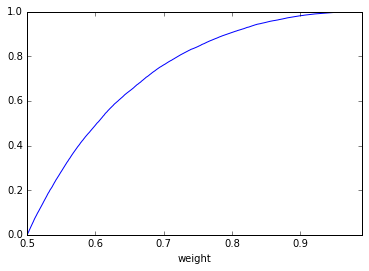

In [99]:
cum_dist = np.linspace(0.,1.,len(l))
cdf = pd.Series(cum_dist, index=l)
cdf.plot()

In [100]:
dic=cdf.to_dict()
lsi_df['p']=lsi_df.weight.apply(lambda x :1- dic[x])

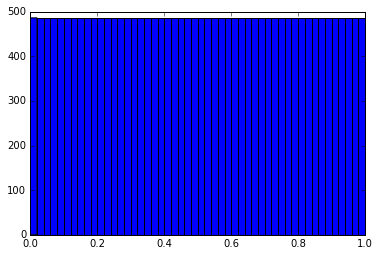

In [101]:
p=lsi_df.p
binwidth=.01
hist=plt.hist(p,50 )

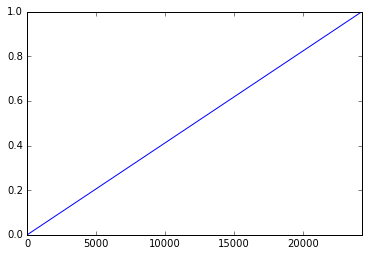

In [102]:
p=lsi_df.p
p=p.sort_values()
p=p.reset_index(drop=True)
p.plot(drawstyle='steps')

In [103]:
lsi_df['original_weight']=lsi_df.weight
lsi_df.drop('weight',inplace=True,axis=1)
lsi_df['weight']=1-lsi_df.p
lsi_df[['source','target','weight','type']].to_csv('../csv/p_lsi.csv',index=False)

In [104]:
lsi_df.shape

(24265, 6)